In [43]:
import os
from os.path import join as pjoin
from tifffile import imread, imwrite
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, median_filter
from NatMovie_utils import *
from wfield import *


In [4]:
path_summary = 'Y:/WF_VC_liuzhaoxi/______________natural_movie_summary2'
os.makedirs(path_summary, exist_ok=True)

In [45]:
warped_height, warped_width = (540, 640)

ccf_regions_reference,proj,brain_outline = allen_load_reference('dorsal_cortex')
lmarks = load_allen_landmarks(None)

# this converts to warped image space
ccf_regions = allen_transform_regions(None,ccf_regions_reference,
                                      resolution = lmarks['resolution'],
                                        bregma_offset = lmarks['bregma_offset'])

atlas, areanames, brain_mask = atlas_from_landmarks_file(landmarks_file=None, reference='dorsal_cortex', dims = [warped_height, warped_width], do_transform = None) 

In [46]:

area_list = ['MOB','FRP','MOp','MOs','SSp-n','SSp-m','SSp-un','PL','ACAd','RSPv','RSPd','RSPagl','VISC',
             'SSs','SSp-bfd','SSp-tr','SSp-ll','SSp-ul','TEa','AUDd','AUDp','AUDpo','AUDv',
             'VISli','VISpor','VISpl','VISpm','VISl','VISal','VISrl','VISa','VISam','VISp']


## compare snr

In [47]:
all_area_snr_movie = np.load(pjoin(path_summary, 'natural-movie-series','all_area_snr.npy'))
all_area_snr_mvBar = np.load(pjoin(path_summary, 'moving-bar','all_area_snr.npy'))


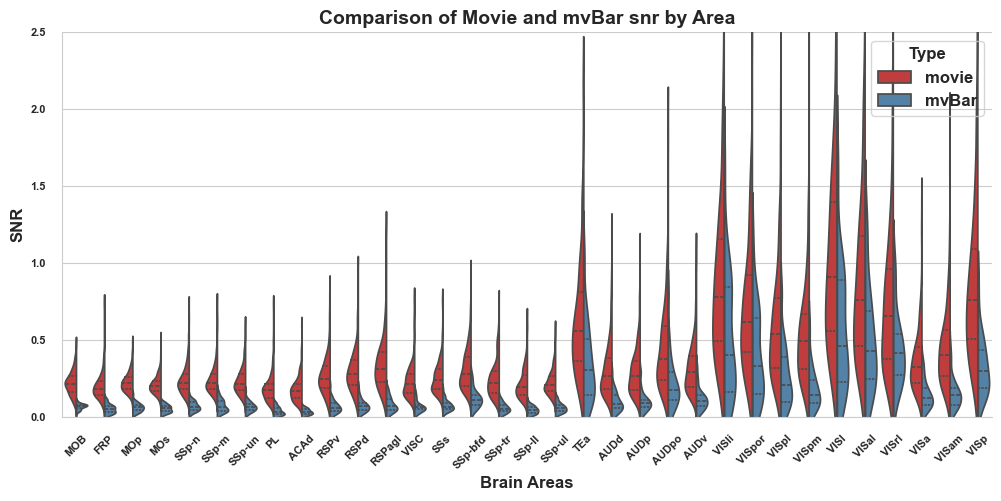

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 将两组数据分别转换为 DataFrame 并展开
df_movie = pd.DataFrame(all_area_snr_movie.reshape(33, -1).T, columns=area_list)
df_movie_long = df_movie.melt(var_name='areas', value_name='snr')  # 转换为长格式
df_movie_long['type'] = 'movie'  # 添加类型标识

df_bar = pd.DataFrame(all_area_snr_mvBar.reshape(33, -1).T, columns=area_list)
df_bar_long = df_bar.melt(var_name='areas', value_name='snr')  # 转换为长格式
df_bar_long['type'] = 'mvBar'  # 添加类型标识

# 合并两组长格式数据
df_combined = pd.concat([df_movie_long, df_bar_long], axis=0)

# 绘制提琴图
plt.figure(figsize=(12, 5))
sns.violinplot(x='areas', y='snr', hue='type', data=df_combined, split=True, density_norm='width', inner='quartile', palette={'movie': 'tab:red', 'mvBar': 'steelblue'})
plt.title('Comparison of Movie and mvBar snr by Area')
plt.xlabel('Brain Areas')
plt.ylabel('SNR')
plt.ylim(0,2.5)
plt.xticks(rotation=45)
plt.legend(title='Type')
fig = plt.gcf()  # 获取当前图形对象
fig.set_facecolor('white')  # 设置背景为白色
plt.savefig(pjoin(path_summary, 'comparison_movie_bar_snr.png'), facecolor='white', transparent=False, bbox_inches='tight', pad_inches=0)
plt.show()


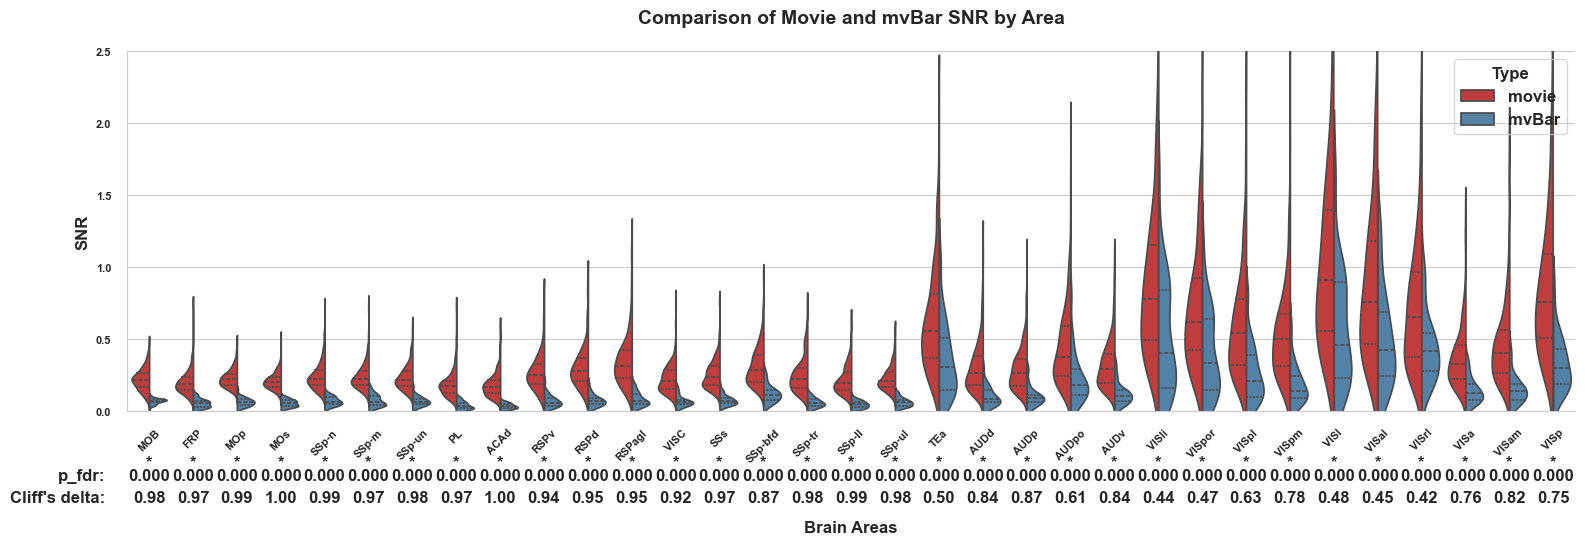

       area       p_value     delta         p_fdr  significant
2       MOp  7.550967e-22  0.993697  8.306064e-21         True
3       MOs  5.086098e-22  0.997899  8.306064e-21         True
8      ACAd  6.620266e-22  0.995098  8.306064e-21         True
16   SSp-ll  1.692564e-21  0.985061  1.060401e-20         True
17   SSp-ul  1.928002e-21  0.983660  1.060401e-20         True
4     SSp-n  1.551647e-21  0.985994  1.060401e-20         True
6    SSp-un  3.037072e-21  0.978758  1.431762e-20         True
15   SSp-tr  4.106615e-21  0.975490  1.505759e-20         True
0       MOB  3.933614e-21  0.975957  1.505759e-20         True
7        PL  4.572735e-21  0.974323  1.509002e-20         True
13      SSs  5.201568e-21  0.972923  1.560470e-20         True
1       FRP  7.981654e-21  0.968254  2.194955e-20         True
5     SSp-m  9.467412e-21  0.966387  2.403266e-20         True
10     RSPd  2.849164e-20  0.954248  6.715887e-20         True
11   RSPagl  4.618158e-20  0.948880  1.015995e-19      

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection

# 计算Cliff's delta的函数
def cliffs_delta(x, y):
    nx, ny = len(x), len(y)
    wins = np.sum([np.sum(xi > y) - np.sum(xi < y) for xi in x])
    return wins / (nx * ny)

# 将两组数据分别转换为 DataFrame 并展开
df_movie = pd.DataFrame(all_area_snr_movie.reshape(33, -1).T, columns=area_list)
df_bar = pd.DataFrame(all_area_snr_mvBar.reshape(33, -1).T, columns=area_list)

# 进行统计检验
results = []
for area in area_list:
    # Mann-Whitney U检验
    u_stat, p = mannwhitneyu(df_movie[area].dropna(), df_bar[area].dropna(), alternative='two-sided')
    # 计算效应量
    delta = cliffs_delta(df_movie[area].dropna(), df_bar[area].dropna())
    results.append({'area': area, 'p_value': p, 'delta': delta})

# 转换为DataFrame并做FDR校正
df_results = pd.DataFrame(results)
df_results['p_fdr'] = fdrcorrection(df_results['p_value'])[1]
df_results['significant'] = df_results['p_fdr'] < 0.05

# 准备绘图数据
df_movie_long = df_movie.melt(var_name='areas', value_name='snr')
df_movie_long['type'] = 'movie'
df_bar_long = df_bar.melt(var_name='areas', value_name='snr')
df_bar_long['type'] = 'mvBar'
df_combined = pd.concat([df_movie_long, df_bar_long], axis=0)

# 绘制提琴图
plt.figure(figsize=(16, 6))
ax = sns.violinplot(x='areas', y='snr', hue='type', data=df_combined, 
                   split=True, density_norm='width', inner='quartile', 
                   palette={'movie': 'tab:red', 'mvBar': 'steelblue'})

# 设置标题和坐标轴
plt.title('Comparison of Movie and mvBar SNR by Area', pad=20)
plt.xlabel('Brain Areas', labelpad=40)  # 增加x轴标签的padding
plt.ylabel('SNR')
plt.ylim(0, 2.5)
plt.xticks(rotation=45)
plt.legend(title='Type')

# 添加统计标注
for i, area in enumerate(area_list):
    area_result = df_results[df_results['area'] == area].iloc[0]
    
    # 第一行：显著性星号
    if area_result['significant']:
        ax.text(i, -0.35, '*', ha='center', va='center', fontsize=12)
    
    # 第二行：p_fdr值
    ax.text(i, -0.45, f"{area_result['p_fdr']:.3f}", ha='center', va='center')
    
    # 第三行：Cliff's delta
    ax.text(i, -0.6, f"{area_result['delta']:.2f}", ha='center', va='center')

# 添加图例说明
ax.text(-1, -0.45, 'p_fdr:', ha='right', va='center')
ax.text(-1, -0.6, 'Cliff\'s delta:', ha='right', va='center')

# 设置白色背景
fig = plt.gcf()
fig.set_facecolor('white')
ax.set_facecolor('white')

# 调整布局防止标注被截断
plt.tight_layout()
plt.subplots_adjust(bottom=0.3)  # 为统计标注留出空间

# 保存图像
plt.savefig(pjoin(path_summary, 'comparison_movie_bar_snr with significance.png'), 
            facecolor='white', transparent=False, 
            bbox_inches='tight', dpi=300)
plt.show()

# 输出统计结果表格
print(df_results.sort_values('p_fdr'))

## compare std

In [49]:
all_area_std_movie = np.load(pjoin(path_summary, 'natural-movie-series','all_area_std.npy'))
all_area_std_mvBar = np.load(pjoin(path_summary, 'moving-bar','all_area_std.npy'))
all_area_std_baseline = np.load(pjoin(path_summary, 'baseline','all_area_std.npy'))


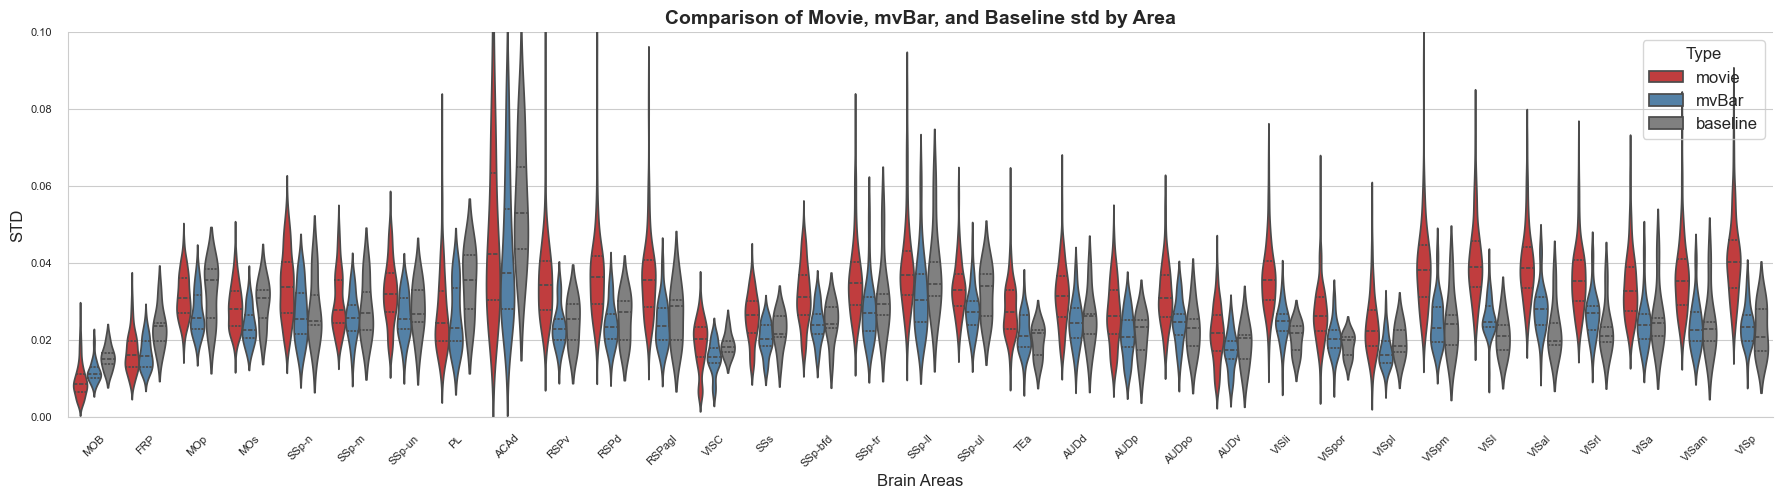

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 将三组数据分别转换为 DataFrame 并展开
df_movie = pd.DataFrame(all_area_std_movie.reshape(33, -1).T, columns=area_list)
df_movie_long = df_movie.melt(var_name='areas', value_name='std')  # 转换为长格式
df_movie_long['type'] = 'movie'  # 添加类型标识

df_mvBar = pd.DataFrame(all_area_std_mvBar.reshape(33, -1).T, columns=area_list)
df_mvBar_long = df_mvBar.melt(var_name='areas', value_name='std')  # 转换为长格式
df_mvBar_long['type'] = 'mvBar'  # 添加类型标识

df_baseline = pd.DataFrame(all_area_std_baseline.reshape(33, -1).T, columns=area_list)
df_baseline_long = df_baseline.melt(var_name='areas', value_name='std')  # 转换为长格式
df_baseline_long['type'] = 'baseline'  # 添加类型标识

# 合并三组长格式数据
df_combined = pd.concat([df_movie_long, df_mvBar_long, df_baseline_long], axis=0)

# 绘制小提琴图
plt.figure(figsize=(22, 5))
sns.violinplot(x='areas', y='std', hue='type', data=df_combined, density_norm='width', inner='quartile', palette={'movie': 'tab:red', 'mvBar': 'steelblue', 'baseline': 'grey'})
plt.title('Comparison of Movie, mvBar, and Baseline std by Area')
plt.xlabel('Brain Areas')
plt.ylabel('STD')
plt.ylim(0, 0.1)  # 设置 y 轴范围
plt.xticks(rotation=45)
plt.legend(title='Type')
fig = plt.gcf()  # 获取当前图形对象
fig.set_facecolor('white')  # 设置背景为白色
plt.savefig(pjoin(path_summary, 'comparison_movie_mvBar_baseline_std.png'), facecolor='white', transparent=False, bbox_inches='tight', pad_inches=0)
plt.show()


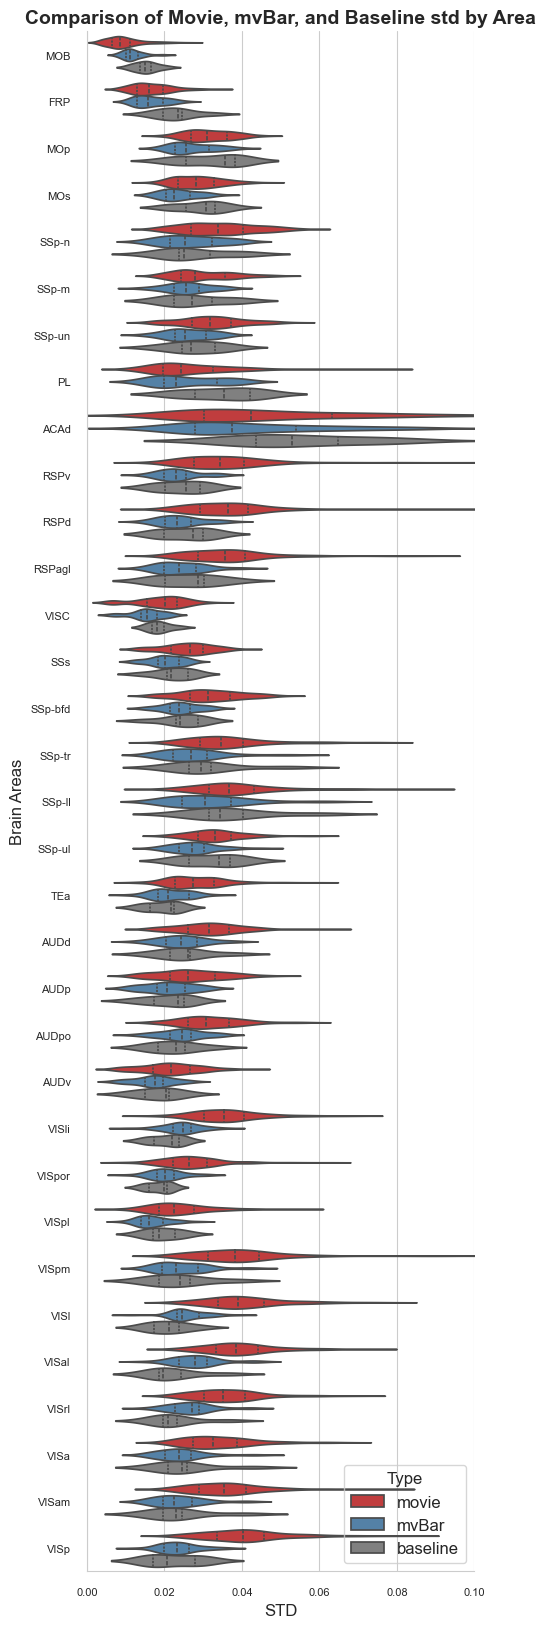

In [51]:
# 绘制横向提琴图
plt.figure(figsize=(5, 20))
sns.violinplot(y='areas', x='std', hue='type', data=df_combined, density_norm='width', inner='quartile', orient='h', 
               palette={'movie': 'tab:red', 'mvBar': 'steelblue', 'baseline': 'grey'})  # 使用 orient='h' 实现横向绘图
plt.title('Comparison of Movie, mvBar, and Baseline std by Area')
plt.ylabel('Brain Areas')  # y 轴为脑区分组
plt.xlabel('STD')  # x 轴为分布数据
plt.xlim(0, 0.1)  # 设置 x 轴范围
plt.legend(title='Type', loc='lower right')  # 调整图例位置
fig = plt.gcf()  # 获取当前图形对象
fig.set_facecolor('white')  # 设置背景为白色
plt.savefig(pjoin(path_summary, 'comparison_movie_mvBar_baseline_std_horizontal.png'), facecolor='white', transparent=False, bbox_inches='tight', pad_inches=0)
plt.show()


## compare correlation

每组数据都是三维的：
第一维：重复
第二维：33个脑区
第三维：33个脑区

In [9]:
area_list1 = ['MOB','FRP','MOp','MOs','PL','ACAd','RSPv','RSPd','RSPagl','VISC',
             'SSp-n','SSp-m','SSp-un','SSs','SSp-bfd','SSp-tr','SSp-ll','SSp-ul','TEa','AUDd','AUDp','AUDpo','AUDv',
             'VISli','VISpor','VISpl','VISpm','VISl','VISal','VISrl','VISa','VISam','VISp']

In [7]:
corr_baseline = np.load(pjoin(path_summary, 'baseline', 'all_area_correlation.npy'))
corr_mvbar = np.load(pjoin(path_summary, 'moving-bar', 'all_area_correlation.npy'))
corr_movie = np.load(pjoin(path_summary, 'natural-movie-series', 'all_area_correlation.npy'))

### 设置比较的两组数据：corr_stimA和corr_stimB

In [190]:
corr_stimA = corr_mvbar
corr_stimB = corr_movie
stimA = 'bar'
stimB = 'movie'

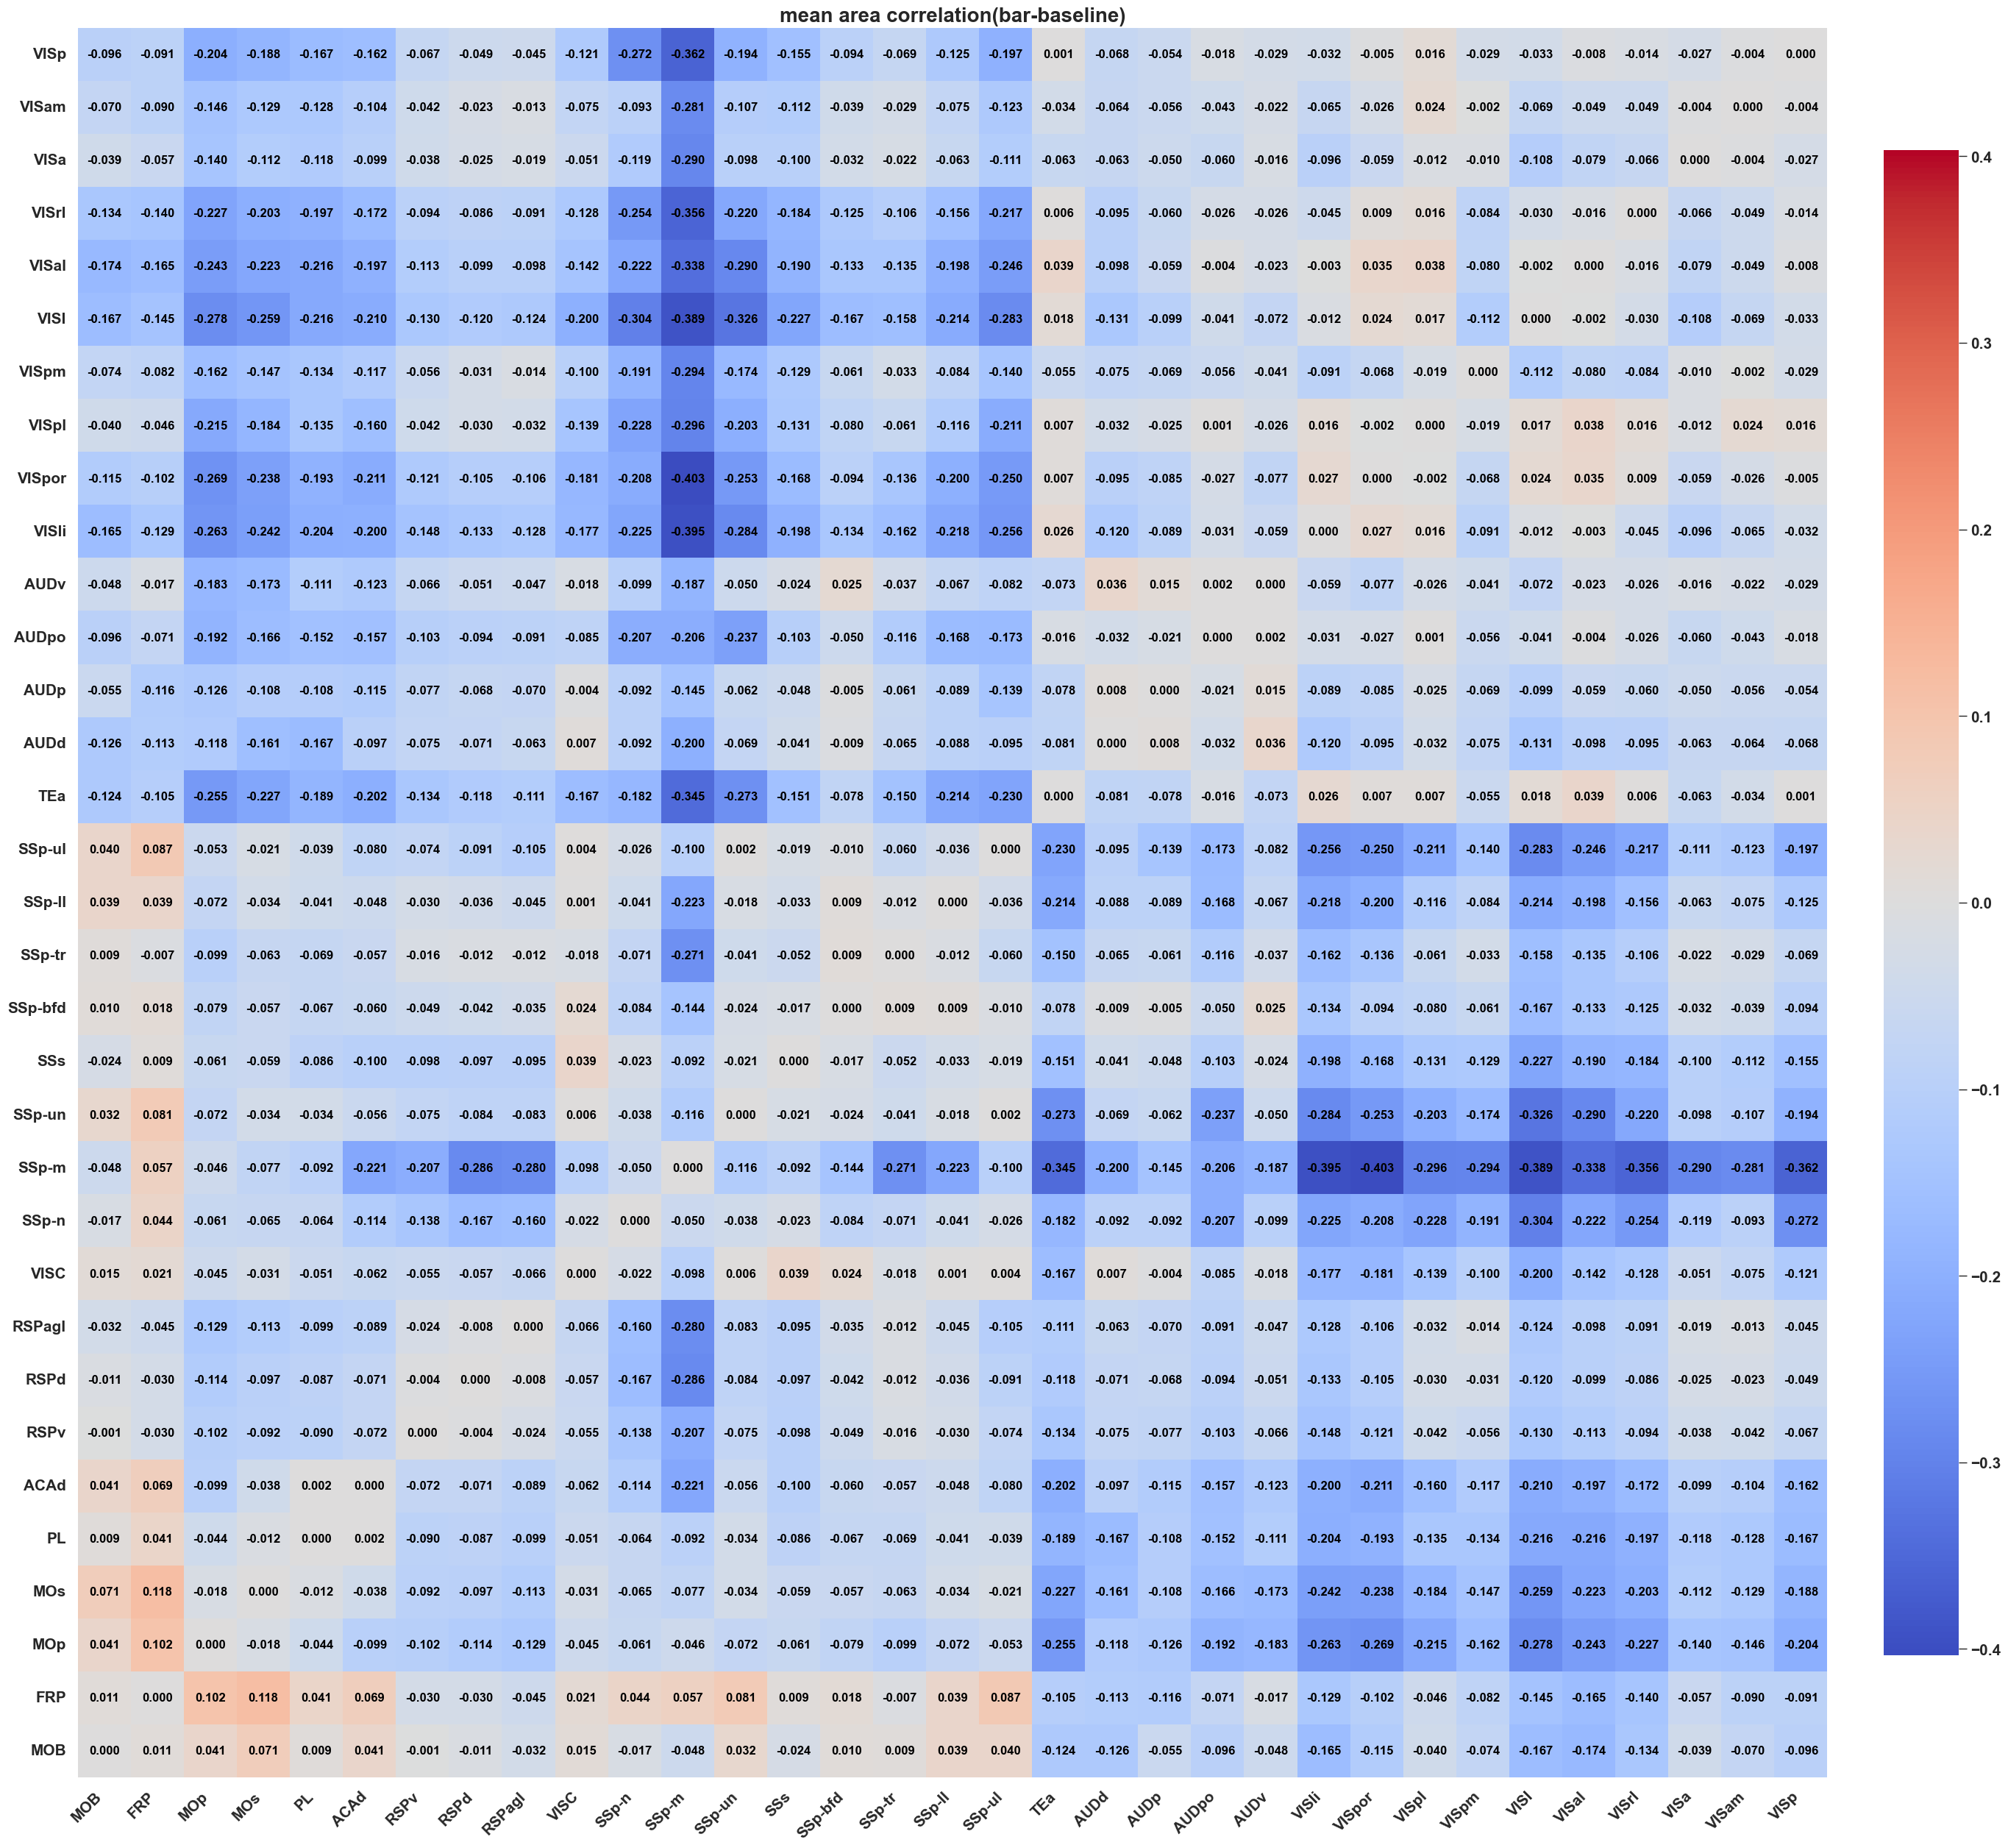

In [181]:
delta_corr = corr_stimB.mean(axis=0) - corr_stimA.mean(axis=0)
vmax = np.maximum(np.abs(delta_corr.min()), np.abs(delta_corr.max()))
vmin = -vmax

plot_heatmap(delta_corr, xlabel=area_list1, ylabel=area_list1,
             cmap='coolwarm', vmin=vmin, vmax=vmax, title=f'mean area correlation({stimB}-{stimA})',
             outfile=pjoin(path_summary, f'mean area correlation({stimB}-{stimA}).png'), dpi=300, annot=True)

In [191]:
## 提取下三角元素（排除对角线）

import scipy.stats as stats

def extract_lower_triangular(matrices):
    n_repeats, n_rois, _ = matrices.shape
    lower_tri_indices = np.tril_indices(n_rois, k=-1)  # k=-1排除对角线
    return np.array([matrices[i][lower_tri_indices] for i in range(n_repeats)])

stimA_edges = extract_lower_triangular(corr_stimA)  # 形状 (n_rep, 528) = repeats × (33*32/2) edges
stimB_edges = extract_lower_triangular(corr_stimB)


### (1) 全局网络差异检验
比较两种状态下整个大脑网络的连接强度是否有明显变化

<br/>

统计方法：
计算每次实验的全网平均连接强度
使用Mann-Whitney U检验比较两组平均值
计算效应量(Cliff's delta)看差异有多大

<br/>

结果解读：
p值 < 0.05：两组有显著差异
效应量：0.147(小)、0.33(中)、0.474(大)

In [192]:
def cliffs_delta(x, y):
    nx, ny = len(x), len(y)
    wins = sum(1 for i in x for j in y if i > j) - sum(1 for i in x for j in y if i < j)
    return wins / (nx * ny)

In [194]:
# 计算每次重复的平均连接强度
stimA_global = np.mean(stimA_edges, axis=1)  
stimB_global = np.mean(stimB_edges, axis=1)       
# stimA_global = stimA_edges.reshape(-1)  
# stimB_global = stimB_edges.reshape(-1)         
# Mann-Whitney U检验 + 效应量
U_global, p_global = stats.mannwhitneyu(stimA_global, stimB_global, alternative='two-sided')
cliffs_delta_global = cliffs_delta(stimA_global, stimB_global)  # 使用前文定义的cliffs_delta函数

print(f"Global: U={U_global}, p={p_global:.4f}, delta={cliffs_delta_global:.3f}")

Global: U=13.0, p=0.0549, delta=-0.587


### (2) 逐连接边分析
目标：找出具体是哪些脑区之间的连接发生了变化

为什么要校正？
同时检验528条连接，不做校正的话假阳性率很高


In [186]:
from statsmodels.stats.multitest import fdrcorrection

n_edges = stimA_edges.shape[1]
p_values = np.zeros(n_edges)

for i in range(n_edges):
    _, p_values[i] = stats.mannwhitneyu(stimA_edges[:, i], stimB_edges[:, i], alternative='two-sided')

# FDR校正
_, p_fdr = fdrcorrection(p_values, alpha=0.05)
significant_edges = np.where(p_fdr < 0.05)[0]  # 显著边的索引

print(f'显著差异的脑区对总数：校正前 {sum(p_values<0.05)}，校正后{sum(p_fdr<0.05)}')

显著差异的脑区对总数：校正前 45，校正后0


### (3) 关键脑区分析
目标:
识别在两组刺激中差异最显著的脑区节点。

方法：
统计每个脑区参与了多少条显著变化的连接


In [187]:
# 统计每个脑区参与的显著边数量
n_rois = 33
significant_edge_counts = np.zeros(n_rois)

# 将边的索引映射回脑区对
lower_tri_indices = np.tril_indices(n_rois, k=-1)
for edge_idx in significant_edges:
    i, j = lower_tri_indices[0][edge_idx], lower_tri_indices[1][edge_idx]
    significant_edge_counts[i] += 1
    significant_edge_counts[j] += 1

# 找出差异最显著的脑区（仅包含参与显著连接的脑区）
significant_rois = np.where(significant_edge_counts > 0)[0]  # 获取有显著连接的脑区索引

if len(significant_rois) > 0:
    # 按参与数量降序排列
    sorted_indices = np.argsort(-significant_edge_counts[significant_rois])
    sorted_significant_rois = significant_rois[sorted_indices]
    
    # 构建DataFrame
    result_df = pd.DataFrame(
        data=[significant_edge_counts[sorted_significant_rois]],  # 第一行数据（参与数量）
        columns=[area_list1[roi] for roi in sorted_significant_rois]  # 列名（脑区名称）
    )
    
    # 导出CSV
    result_df.to_csv(pjoin(path_summary, f"correlation difference significant brain area ({stimB}-{stimA}).csv"), index=False)
    print("CSV已保存，包含以下显著脑区：")
    print(result_df)
else:
    print("没有显著差异的脑区，未生成CSV文件")

没有显著差异的脑区，未生成CSV文件


In [173]:
# def plot_heatmap_sig(data, significant_edges, xlabel=None, ylabel=None, vmin = None, vmax = None, 
#                     title=None, global_stats=None, outfile=None, dpi=300, 
#                     cmap='coolwarm', **kwargs):
#     """
#     带显著性标记的热图绘制（绿色点阵+斜线纹理）
#     Parameters:
#         data: 要绘制的矩阵 (n x n)
#         significant_edges: 下三角显著边的索引数组
#         global_stats: 全局统计信息字符串 (如"U=103.0, p=0.0042, delta=0.731")
#     """
#     import numpy as np
#     import seaborn as sns
#     import matplotlib.pyplot as plt
#     from matplotlib.patches import Circle, PathPatch
#     from matplotlib.path import Path
# 
#     if vmin == None and vmax == None:
#         vmax = np.maximum(np.abs(data.min()), np.abs(data.max()))
#         vmin = -vmax
# 
#     # 设置全局样式
#     plt.rcParams['text.usetex'] = False
#     plt.rcParams['axes.titleweight'] = 'bold'
#     plt.rcParams['axes.labelweight'] = 'bold'
# 
#     # 创建显著性掩码
#     n_rois = data.shape[0]
#     sig_mask = np.zeros_like(data, dtype=bool)
#     triu_idx = np.triu_indices_from(data, k=1)
#     for edge in significant_edges:
#         i, j = triu_idx[0][edge], triu_idx[1][edge]
#         sig_mask[i,j] = sig_mask[j,i] = True
# 
#     # 创建带星号的annot矩阵
#     annot_matrix = np.array([[""]*n_rois]*n_rois, dtype=object)
#     for i in range(n_rois):
#         for j in range(n_rois):
#             val = f"{data[i,j]:.3f}"
#             annot_matrix[i,j] = f"$\mathbf{{{val}}}$*" if sig_mask[i,j] else val
#             # annot_matrix[i,j] = "" if sig_mask[i,j] else val
# 
# 
#     # 绘制基础热图
#     fig, ax = plt.subplots(figsize=(10, 8))
#     heatmap_kws = {
#         "annot": annot_matrix,
#         "fmt": "",
#         "annot_kws": {"size": 3, "color": "black"},
#         "cmap": cmap,
#         "square": True,
#         "linewidths": 0.5,
#         "linecolor": "lightgray",
#         "ax": ax, 
#         "vmin": vmin, 
#         "vmax": vmax
#     }
#     heatmap_kws.update({k:v for k,v in kwargs.items() if k not in heatmap_kws})
#     sns.heatmap(data, **heatmap_kws)
# 
#     # 添加纹理（显著=绿色点阵，非显著=斜线）
#     for i in range(n_rois):
#         for j in range(n_rois):
#             if sig_mask[i,j]:
#                 '''
#                 # 显著单元格数值绿色加粗
#                 val = f"{data[i,j]:.3f}"
#                 ax.text(j+0.5, i+0.5, f"$\mathbf{{{val}}}$*", 
#                        ha='center', va='center',
#                        fontsize=3, color='darkgreen', weight='bold')
#                 
#                 # 绿色点阵纹理
#                 for x in np.linspace(j+0.1, j+0.9, 5):
#                     for y in np.linspace(i+0.1, i+0.9, 5):
#                         ax.add_patch(Circle(
#                             (x, y), radius=0.02,
#                             facecolor='darkgreen',
#                             edgecolor='darkgreen',
#                             alpha=0.7,
#                             linewidth=0.5
#                         ))
#                         '''
#             else:
#                 '''
#                 # 非显著单元格：灰色斜线
#                 path = Path([(j, i), (j+1, i+1)])
#                 ax.add_patch(PathPatch(
#                     path, 
#                     lw=0.5, 
#                     edgecolor='gray', 
#                     facecolor='none',
#                     alpha=1,
#                     linestyle='-'  # 虚线样式
#                 ))
#                 '''
# 
#     # 全局统计信息
#     if global_stats:
#         ax.text(0.5, 1.02,  
#               f"Global difference significance: {global_stats}", 
#               ha="center", transform=ax.transAxes,
#               fontsize=10,
#               bbox=dict(facecolor="white", alpha=1, edgecolor="gray"))
# 
#     # 坐标轴和标题
#     if xlabel: 
#         ax.set_xticklabels(xlabel, rotation=45, ha="right", fontsize=8)
#     if ylabel: 
#         ax.set_yticklabels(ylabel, rotation=0, fontsize=8)
#     if title: 
#         ax.set_title(title, pad=40, fontsize=20, fontweight="bold")
#     
#     if outfile:
#         plt.savefig(outfile, bbox_inches="tight", dpi=dpi, facecolor="white")
#     
#     plt.show()

In [174]:
def plot_heatmap_sig(data, significant_edges, xlabel=None, ylabel=None, vmin=None, vmax=None, 
                    title=None, global_stats=None, outfile=None, dpi=300, 
                    cmap='coolwarm', **kwargs):
    """
    带显著性标记的热图绘制（非显著单元格纯灰色）
    Parameters:
        data: 要绘制的矩阵 (n x n)
        significant_edges: 下三角显著边的索引数组
        global_stats: 全局统计信息字符串
    """
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from matplotlib.colors import LinearSegmentedColormap

    # 自动设置vmin/vmax
    if vmin is None and vmax is None:
        vmax = np.maximum(np.abs(data.min()), np.abs(data.max()))
        vmin = -vmax

    # 创建显著性掩码
    n_rois = data.shape[0]
    sig_mask = np.zeros_like(data, dtype=bool)
    triu_idx = np.triu_indices_from(data, k=1)
    for edge in significant_edges:
        i, j = triu_idx[0][edge], triu_idx[1][edge]
        sig_mask[i,j] = sig_mask[j,i] = True

    # 创建带星号的annot矩阵
    annot_matrix = np.array([[""]*n_rois]*n_rois, dtype=object)
    for i in range(n_rois):
        for j in range(n_rois):
            val = f"{data[i,j]:.3f}"
            annot_matrix[i,j] = f"{val}*" if sig_mask[i,j] else val

    # 创建混合colormap（显著=原cmap，非显著=纯灰色）
    gray_color = "#D3D3D3"  # 浅灰色（可修改为任意HEX颜色）
    mixed_data = np.where(sig_mask, data, np.nan)  # 非显著区域设为nan
    
    # 绘制热图
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # 先绘制灰色背景（所有单元格）
    sns.heatmap(np.full_like(data, 0),  # 填充0值
                cmap=LinearSegmentedColormap.from_list("gray", [gray_color, gray_color]),
                cbar=False, square=True, linewidths=0.5, linecolor='lightgray',
                ax=ax)
    
    # 再绘制显著单元格（覆盖灰色背景）
    sns.heatmap(mixed_data, annot=annot_matrix, fmt="",
                annot_kws={"size": 3, "color": "black", "weight": "bold"},
                cmap=cmap, square=True, linewidths=0.5,
                linecolor='lightgray', vmin=vmin, vmax=vmax, ax=ax)

    # 全局统计信息
    if global_stats:
        ax.text(0.5, 1.02,  
              f"Global difference significance: {global_stats}", 
              ha="center", transform=ax.transAxes,
              fontsize=10,
              bbox=dict(facecolor="white", alpha=1, edgecolor="gray"))

    # 坐标轴和标题
    if xlabel: 
        ax.set_xticklabels(xlabel, rotation=45, ha="right", fontsize=8)
    if ylabel: 
        ax.set_yticklabels(ylabel, rotation=0, fontsize=8)
    if title: 
        ax.set_title(title, pad=40, fontsize=20, fontweight="bold")
    
    if outfile:
        plt.savefig(outfile, bbox_inches="tight", dpi=dpi, facecolor="white")
    
    plt.show()

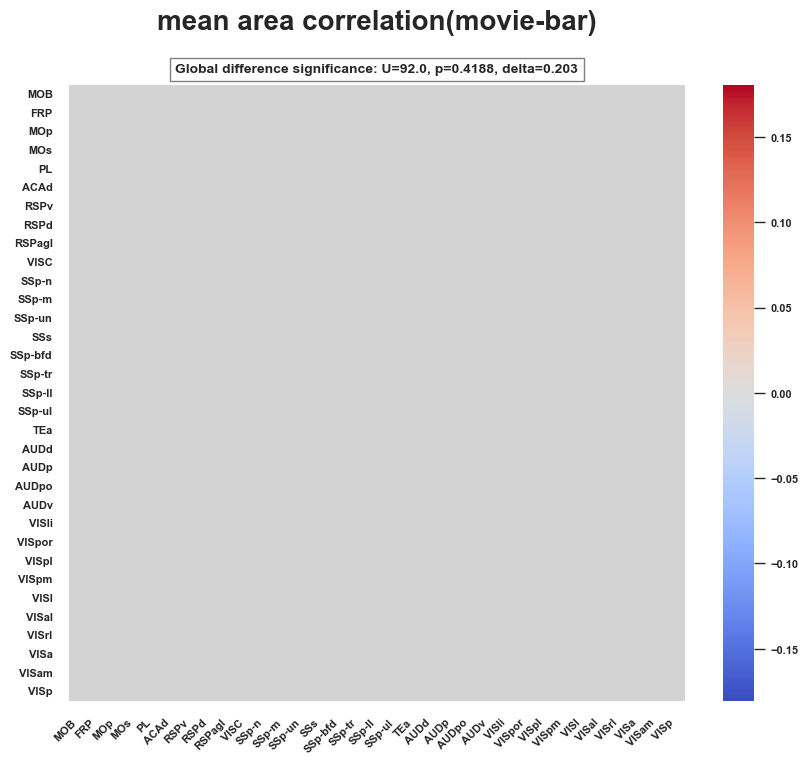

In [175]:
global_stats = f"U={U_global}, p={p_global:.4f}, delta={cliffs_delta_global:.3f}"  # 全局统计结果

plot_heatmap_sig(
    corr_stimB.mean(axis=0) - corr_stimA.mean(axis=0), 
    significant_edges=significant_edges,
    xlabel=area_list1, 
    ylabel=area_list1,
    cmap='coolwarm', annot=True, 
    title=f'mean area correlation({stimB}-{stimA})',
    global_stats=global_stats,
    outfile=pjoin(path_summary, f'mean_area_correlation({stimB}-{stimA}) with significance.png'))
    

## 数据分析说明

### **一、何时使用多重比较校正？**
#### **1. 什么是多重比较问题？**
当对同一数据集进行**多次统计检验**时（例如逐像素、逐时间点、多指标比较），假阳性（Type I错误）的概率会显著增加。  
- **举例**：  
  - 对5×5矩阵的每个位置做Mann-Whitney U检验（共25次检验），若单次检验显著性水平α=0.05，至少出现一个假阳性的概率为：  
    $$ P(\text{至少1个错误}) = 1 - (1-0.05)^{25} ≈ 0.72 $$  
  - 即错误率高达72%！

#### **2. 何时需要校正？**
- **同时检验多个独立假设**：如脑成像中的体素分析、基因差异表达分析、时间序列逐点比较。  
- **数据具有多维结构**：如三维数据中逐位置（voxel-wise）比较。  

#### **3. 常用校正方法**
| 方法                | 适用场景                          | 特点                              | Python实现                        |
|---------------------|-----------------------------------|-----------------------------------|-----------------------------------|
| **Bonferroni**      | 检验次数较少时（如<100次）        | 严格（α/m），但保守               | `p_adjusted = p_values * m`       |
| **FDR（BH法）**     | 检验次数多时（如fMRI、基因组学）  | 控制假发现率，平衡灵敏度和特异性  | `statsmodels.stats.multitest.fdrcorrection` |
| **Permutation**     | 小样本或复杂依赖结构              | 计算代价高，但最稳健              | 自定义重抽样                      |

<br/>


### **二、效应量：Cliff's delta与共同语言效应量（CLES）**
#### **1. 为什么需要效应量？**
- **p值局限性**：仅反映统计显著性，无法衡量差异大小。  
- **效应量**：量化两组差异的**实际重要性**，与样本量无关。  

#### **2. Cliff's delta**  
- **定义**：反映两组数据中一个值大于另一个值的概率差异。  
  $$ \text{delta} = P(X > Y) - P(X < Y) $$  
  - 值域：[-1, 1]，0表示无差异，±1表示完全分离。  
  - **解读**：  
    - 0.147（小效应）  
    - 0.33（中效应）  
    - 0.474（大效应）  


#### **3. 共同语言效应量（CLES）**  
- **定义**：随机抽取一个来自X的值大于一个来自Y的值的概率。  
  $$ \text{CLES} = P(X > Y) + 0.5 \times P(X = Y) $$  
  - 值域：[0, 1]，0.5表示无差异。  
  - **与Cliff's delta关系**：  
    $$ \text{delta} = 2 \times \text{CLES} - 1 $$  


#### **4. 何时使用？**
- **非参数检验后**：如Mann-Whitney U、KS检验，补充效应量。  
- **小样本研究**：避免仅依赖p值导致结论偏差。  
- **跨研究比较**：效应量标准化，便于元分析。  

**示例报告**：  
> "Mann-Whitney U检验显示两组差异显著（U=15, p=0.02），Cliff's delta=0.42（大效应），且CLES=0.71，表明实验组有71%的概率高于对照组。"

<br/>

### **三、完整分析流程建议**
1. **数据检查**：可视化分布（箱线图/ECDF图）。  
2. **统计检验**：选择Mann-Whitney U或其他非参数检验。  
3. **多重比较校正**：若检验次数>1，使用FDR/Bonferroni。  
4. **效应量计算**：报告Cliff's delta或CLES。  
5. **结果整合**：结合p值、效应量和可视化综合解读。  

